In [5]:
from astropy.io import fits

hat = fits.open('hat-p-7_b/hat-p-7_b.fits')

In [6]:
from astropy.table import Table

PRIMARY = hat['PRIMARY']

TCE_1 = hat['TCE_1']
table_tce1 = Table.read(TCE_1) #¿se puede hacer un array de BinTablesHDU?


TCE_2 = hat['TCE_2']
table_tce2 = Table.read(TCE_2) #¿se puede hacer un array de BinTablesHDU?


TCE_3 = hat['TCE_3']
table_tce3 = Table.read(TCE_3) #¿se puede hacer un array de BinTablesHDU?


TCE_4 = hat['TCE_4']
table_tce4 = Table.read(TCE_4) #¿se puede hacer un array de BinTablesHDU?


TCE_5 = hat['TCE_5']
table_tce5 = Table.read(TCE_5) #¿se puede hacer un array de BinTablesHDU?


TCE_6 = hat['TCE_6']
table_tce6 = Table.read(TCE_6) #¿se puede hacer un array de BinTablesHDU?


TCE_7 = hat['TCE_7']
table_tce7 = Table.read(TCE_7)


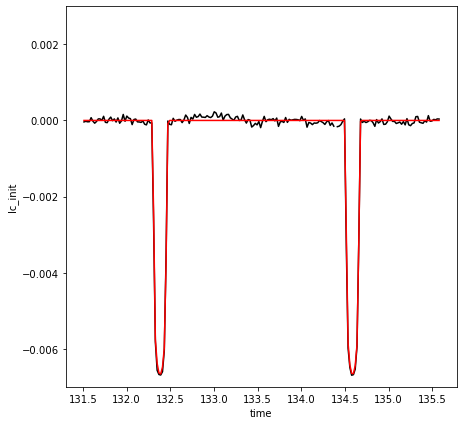

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


tce1_time = table_tce1['TIME'].data
# tce1_timecorr = table_tce1['TIMECORR'].data
# tce1_cadenceno = table_tce1['CADENCENO'].data
# tce1_phase = table_tce1['PHASE'].data
tce1_lc_init = table_tce1['LC_INIT'].data
tce1_lc_init_err = table_tce1['LC_INIT_ERR'].data
tce1_lc_white = table_tce1['LC_WHITE'].data
tce1_lc_detrend = table_tce1['LC_DETREND'].data
tce1_model_init = table_tce1['MODEL_INIT'].data
tce1_model_white = table_tce1['MODEL_WHITE'].data

fig, ax = plt.subplots(figsize=(7,7))

ax.plot(tce1_time[0:200], tce1_lc_init[0:200], '-k')
ax.plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
ax.set_ylim(-0.007,0.003)
ax.set_xlabel('time')
ax.set_ylabel('lc_init')

# fig, ax = plt.subplots(1,3, figsize=(16,16))

# ax[0].plot(tce1_time[0:200], tce1_lc_init[0:200], '-k')
# ax[0].plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
# ax[0].set_ylim(-0.007,0.003)
# ax[0].set_xlabel('time')
# ax[0].set_ylabel('lc_init')

# ax[1].plot(tce1_time[0:200], tce1_lc_white[0:200])
# ax[1].plot(tce1_time[0:200], tce1_model_white[0:200], '-r')
# ax[1].set_ylim(-90, 55)
# ax[1].set_xlabel('time')
# ax[1].set_ylabel('lc_white')

# ax[2].plot(tce1_time[0:200], tce1_lc_detrend[0:200], '-g')
# ax[2].plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
# ax[2].set_ylim(-0.007,0.003)
# ax[2].set_xlabel('time')
# ax[2].set_ylabel('lc_detrend')


plt.show()


In [18]:
from scipy.misc import derivative
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scipy.optimize import curve_fit
%matplotlib inline

def L(r, P, Z): #it is already multiplied by r² as it is in the derivate into the integral
  '''
  Obstruction function
  '''
  p = P/r
  z0 = Z/r
  
  # Reflects the information w.r.t. the y axis  
  if np.all(z0>0):
    z = z0
  if np.all(z0<0):
    z = -z0
    
  if np.all(z>1+p):
    return 0.
  elif (np.all(abs(1-p)<z) and np.all(z<=1+p)):
    k0 = np.arccos((p**2 + z**2 -1)/(2*p*z))
    k1 = np.arccos((1-p**2 + z**2)/(2*z))
    L0 = k0*p**2
    L2 = np.sqrt((4*z**2- (1+z**2-p**2)**2)/4) 
    return (L0 + k1 - L2)*r**2/np.pi
  elif np.all(z<=1-p):
    return p**2*r**2
  elif np.all(z<= p-1): 
    return 1.*r**2


def I_function(r, gamma1, gamma2):
  '''
  Quadratic limb-darkening function
  '''
  mu = np.sqrt(1-r**2) 
  return 1. - gamma1*(1-mu) - gamma2*(1-mu)**2


def integrand_1(r, p, z, gamma1, gamma2):
  '''
  Integrand in the numerator
  '''
  T1 = derivative(L, r, dx=1e-6, args=(p,z))
  T2 = I_function(r, gamma1, gamma2)
  return T1*T2


def integrand_2(r, gamma1, gamma2):
  '''
  Integrand in the denominator
  '''
  return I_function(r, gamma1, gamma2)*2*r




# Grid definition
N = 1000
t = np.linspace(0.,30,N)



def lightcurve_curve_fit(t: float, p:float, b:float, T:float, 
                         delta:float, a:float, gamma1:float, gamma2:float) -> float:
    
    '''
    This function gives the light curve to be fitted
    p -> radius ratio
    b -> impact. parameter
    gamma1 -> linear limb darkening 
    gamma2 -> quadratic limb darkening
    a -> normalized semi-major axis (normalized with the star radius)
    T -> orbital period
    delta -> orbital phase
    
    '''
    omega = 2*np.pi/T #angular velocity
    
    x = a*np.cos(omega*t+delta)
    
    z_range = np.sqrt(x**2 + b**2)
    
    
    # Calculate the Flux
    
    Integral_1 = integrate.quad(integrand_1, 0.0001, 1., args=(p,z_range, gamma1, gamma2))[0]
    Integral_2 = integrate.quad(integrand_2, 0.0001, 1., args=(gamma1, gamma2))[0]
    
    return 1. - Integral_1/Integral_2
    
xdata =  tce1_time[0:100]
ydata = tce1_lc_init[0:100]

popt, pcov = curve_fit(lightcurve_curve_fit, xdata, ydata)


TypeError: only size-1 arrays can be converted to Python scalars

---
## References


1. K. Mandel and E. Agol. *Analytic Lightcurves for Planetary Transit Searches*. [astro-ph:0210099](https://arxiv.org/pdf/astro-ph/0210099.pdf).
2. S. E. Thompson 2016, Data Validation Time Series
File: Description of the File Format and Content, KSCI-19079-001.